# Data imbalance analysis
## Comparing the impact of dataset imbalance on classification performance metrics
In this notebook, we are going to explore how data imbalance affect classification scores on four different tasks, which have been chosen to exemplify typical use cases of ML analysis in neuroscience. To keep it simple, we will focus on binary classification problems (0 vs 1).

The four tasks are :
1. Synthetic data
2. EEG alpha oscillations (resting-state Eyes-Closed vs Eyes-Open)
3. MEG alpha oscillations (auditory vs visual stimulation)
4. MEG alpha oscillations (faces vs scrambled) 

In these tasks, we will observe the effect of data imbalance on 4 different performance metrics :   
1. Decoding Accuracy (Acc)  
2. Area Under the Curve (AUC)
3. F1
4. Balanced Accuracy (BAcc)

Finally, a few parameters of the classification pipeline must be kept in mind as they can also differentially impact performance on imbalanced data. Namely :
- Dataset size
- Classifier type
    - Support Vector Machine (SVM)
    - Linear Discriminant Analysis (LDA)
    - Logistic Regression (LR)
    - Random Forest (RF)
- Cross-validation scheme
    - K-Fold, k=5
    - Stratified K-Fold
    - Group K-Fold

## Imports
First, we start by importing functions from the provided toolbox as well as some useful plotting functions.

In [1]:
from imbalance.pipeline import Pipeline
from imbalance.viz import metric_balance, data_distribution, plot_different_cvs, plot_different_n
from imbalance.data import eegbci, gaussian_binary
from joblib import Parallel, delayed
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    StratifiedGroupKFold,
)
import os
import numpy as np
import matplotlib.pyplot as plt
import string
from copy import deepcopy
import pickle
import warnings
warnings.simplefilter("ignore", RuntimeWarning)
plt.style.use('tableau-colorblind10')

## Task 1 : Synthetic data
For that first classification task, we will generate data from two gaussian distributions, with means of 0 and 2.

In [ ]:
pls = []

def run(distance):
    # generate random data
    x, y, groups = gaussian_binary(n_samples_per_class=500, mean_distance=distance)
    # run the pipeline
    pl = Pipeline(
        x,
        y,
        groups,
        dataset_balance=np.linspace(0.1, 0.9, 25),
        classifiers=["lr", "lda", "svm", "rf"],
        n_permutations=100,
        n_init=40,
    )
    pl.evaluate()
    return deepcopy(pl)



pls = Parallel(n_jobs=-1)(delayed(run)(dist) for dist in [0, 1, 3])

In [ ]:
pls_path = "../imbalance/data/synthetic_pipelines.pickle"
with open(pls_path, "wb") as f:
    pickle.dump(pls, f)

In [ ]:
# generate random data
x, y, groups = gaussian_binary(n_samples_per_class=1500, mean_distance=1)
# run the pipeline
pl_nsamples = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],# "rf"]
    n_permutations=0,
    n_init=40,
    dataset_size=(0.1, 0.33, 1),
)
pl_nsamples.evaluate()

In [ ]:
pl_path = "../imbalance/data/synthetic_pipelines_nsamples.pickle"
with open(pl_path, "wb") as f:
    pickle.dump(pl_nsamples, f)

In [ ]:

pls_crossvals = {}
cv_names = ["KFold", "Stratified"]#, "Stratified Group"]
cvs = [KFold(n_splits=5), StratifiedKFold(n_splits=5)]#, StratifiedGroupKFold(n_splits=5)]
# generate random data
x, y, groups = gaussian_binary(n_samples_per_class=50, mean_distance=1) ## /!\ N=100 in this analysis
# run the pipeline
for idx_cv, cross_val in enumerate(cvs):
    pl = Pipeline(
        x,
        y,
        groups,
        dataset_balance=np.linspace(0.1, 0.9, 25),
        classifiers=["svm"],
        n_permutations=1,
        n_init=40,
        cross_validation=cross_val,
    )
    pl.evaluate()
    pls_crossvals[cv_names[idx_cv]] = deepcopy(pl)
    




In [ ]:
pl_path = "../imbalance/data/synthetic_pipelines_crossvals.pickle"
with open(pl_path, "wb") as f:
    pickle.dump(pls_crossvals, f)

In [ ]:
# generate random data
x, y, groups = gaussian_binary(n_samples_per_class=500, mean_distance=1)
# run the pipeline
pl_balance = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],
    n_permutations=0,
    n_init=40,
    single_balanced_split=True,
)
pl_balance.evaluate()

In [ ]:
pl_path = "../imbalance/data/synthetic_pipelines_balance.pickle"
with open(pl_path, "wb") as f:
    pickle.dump(pl_balance, f)

In [2]:
# load data
with open("../imbalance/data/synthetic_pipelines.pickle", "rb") as f:
    pls = pickle.load(f)



# visualize the result
fig, axes = plt.subplots(5, 4, figsize=(25, 30), dpi=300, 
                         gridspec_kw=dict(height_ratios=[1, 1, 1, 1, 1], width_ratios=[0.1,1,1,1]))
for ax in axes[:,0]:                              
    ax.axis("off")

figtitle = "Synthetic data"
fig.suptitle(figtitle, fontsize=28, y=1.005, fontweight="bold")
classifiers=["lr", "lda", "svm", "rf"]
spot_names = string.ascii_lowercase[:5*4]

show_leg_distrib=True
show_leg_metric=True
spot_idx = 0
for dist_idx, dist in enumerate([0,1,3]):
    for ax_idx, ax in enumerate(axes[:,dist_idx+1]):
        if ax_idx == 0:
            data_distribution(pls[dist_idx], ax=ax, show=False, show_leg=show_leg_distrib)
            show_leg_distrib=False
        elif ax_idx < 5:
            metric_balance(pls[dist_idx], ax=ax, p_threshold=0, show=False, 
                           classifier=classifiers[ax_idx-1], 
                           show_leg=show_leg_metric, show_title=False)
            show_leg_metric = False
        
        ax.text(-0.1, 1.05, spot_names[spot_idx]+")", transform=ax.transAxes, 
            size=20, weight='bold')
        spot_idx += 1
        
cols = ['Distance = 0', 'Distance = 1', 'Distance = 3']
rows = ["Distributions", "LogisticRegression", "LinearDiscriminantAnalysis", "SupportVectorMachine", "RandomForest"]

for ax, col in zip(axes[0,1:], cols):
    ax.set_title(col, size=24)

for idx_ax, (ax, row) in enumerate(zip(axes[:,0], rows)):
    ax.text(0.8,0.5,rows[idx_ax], fontsize=24, ha="right", va="center", rotation=90)#row, rotation=0, size='large', position="center")

fig.tight_layout()
plt.show()

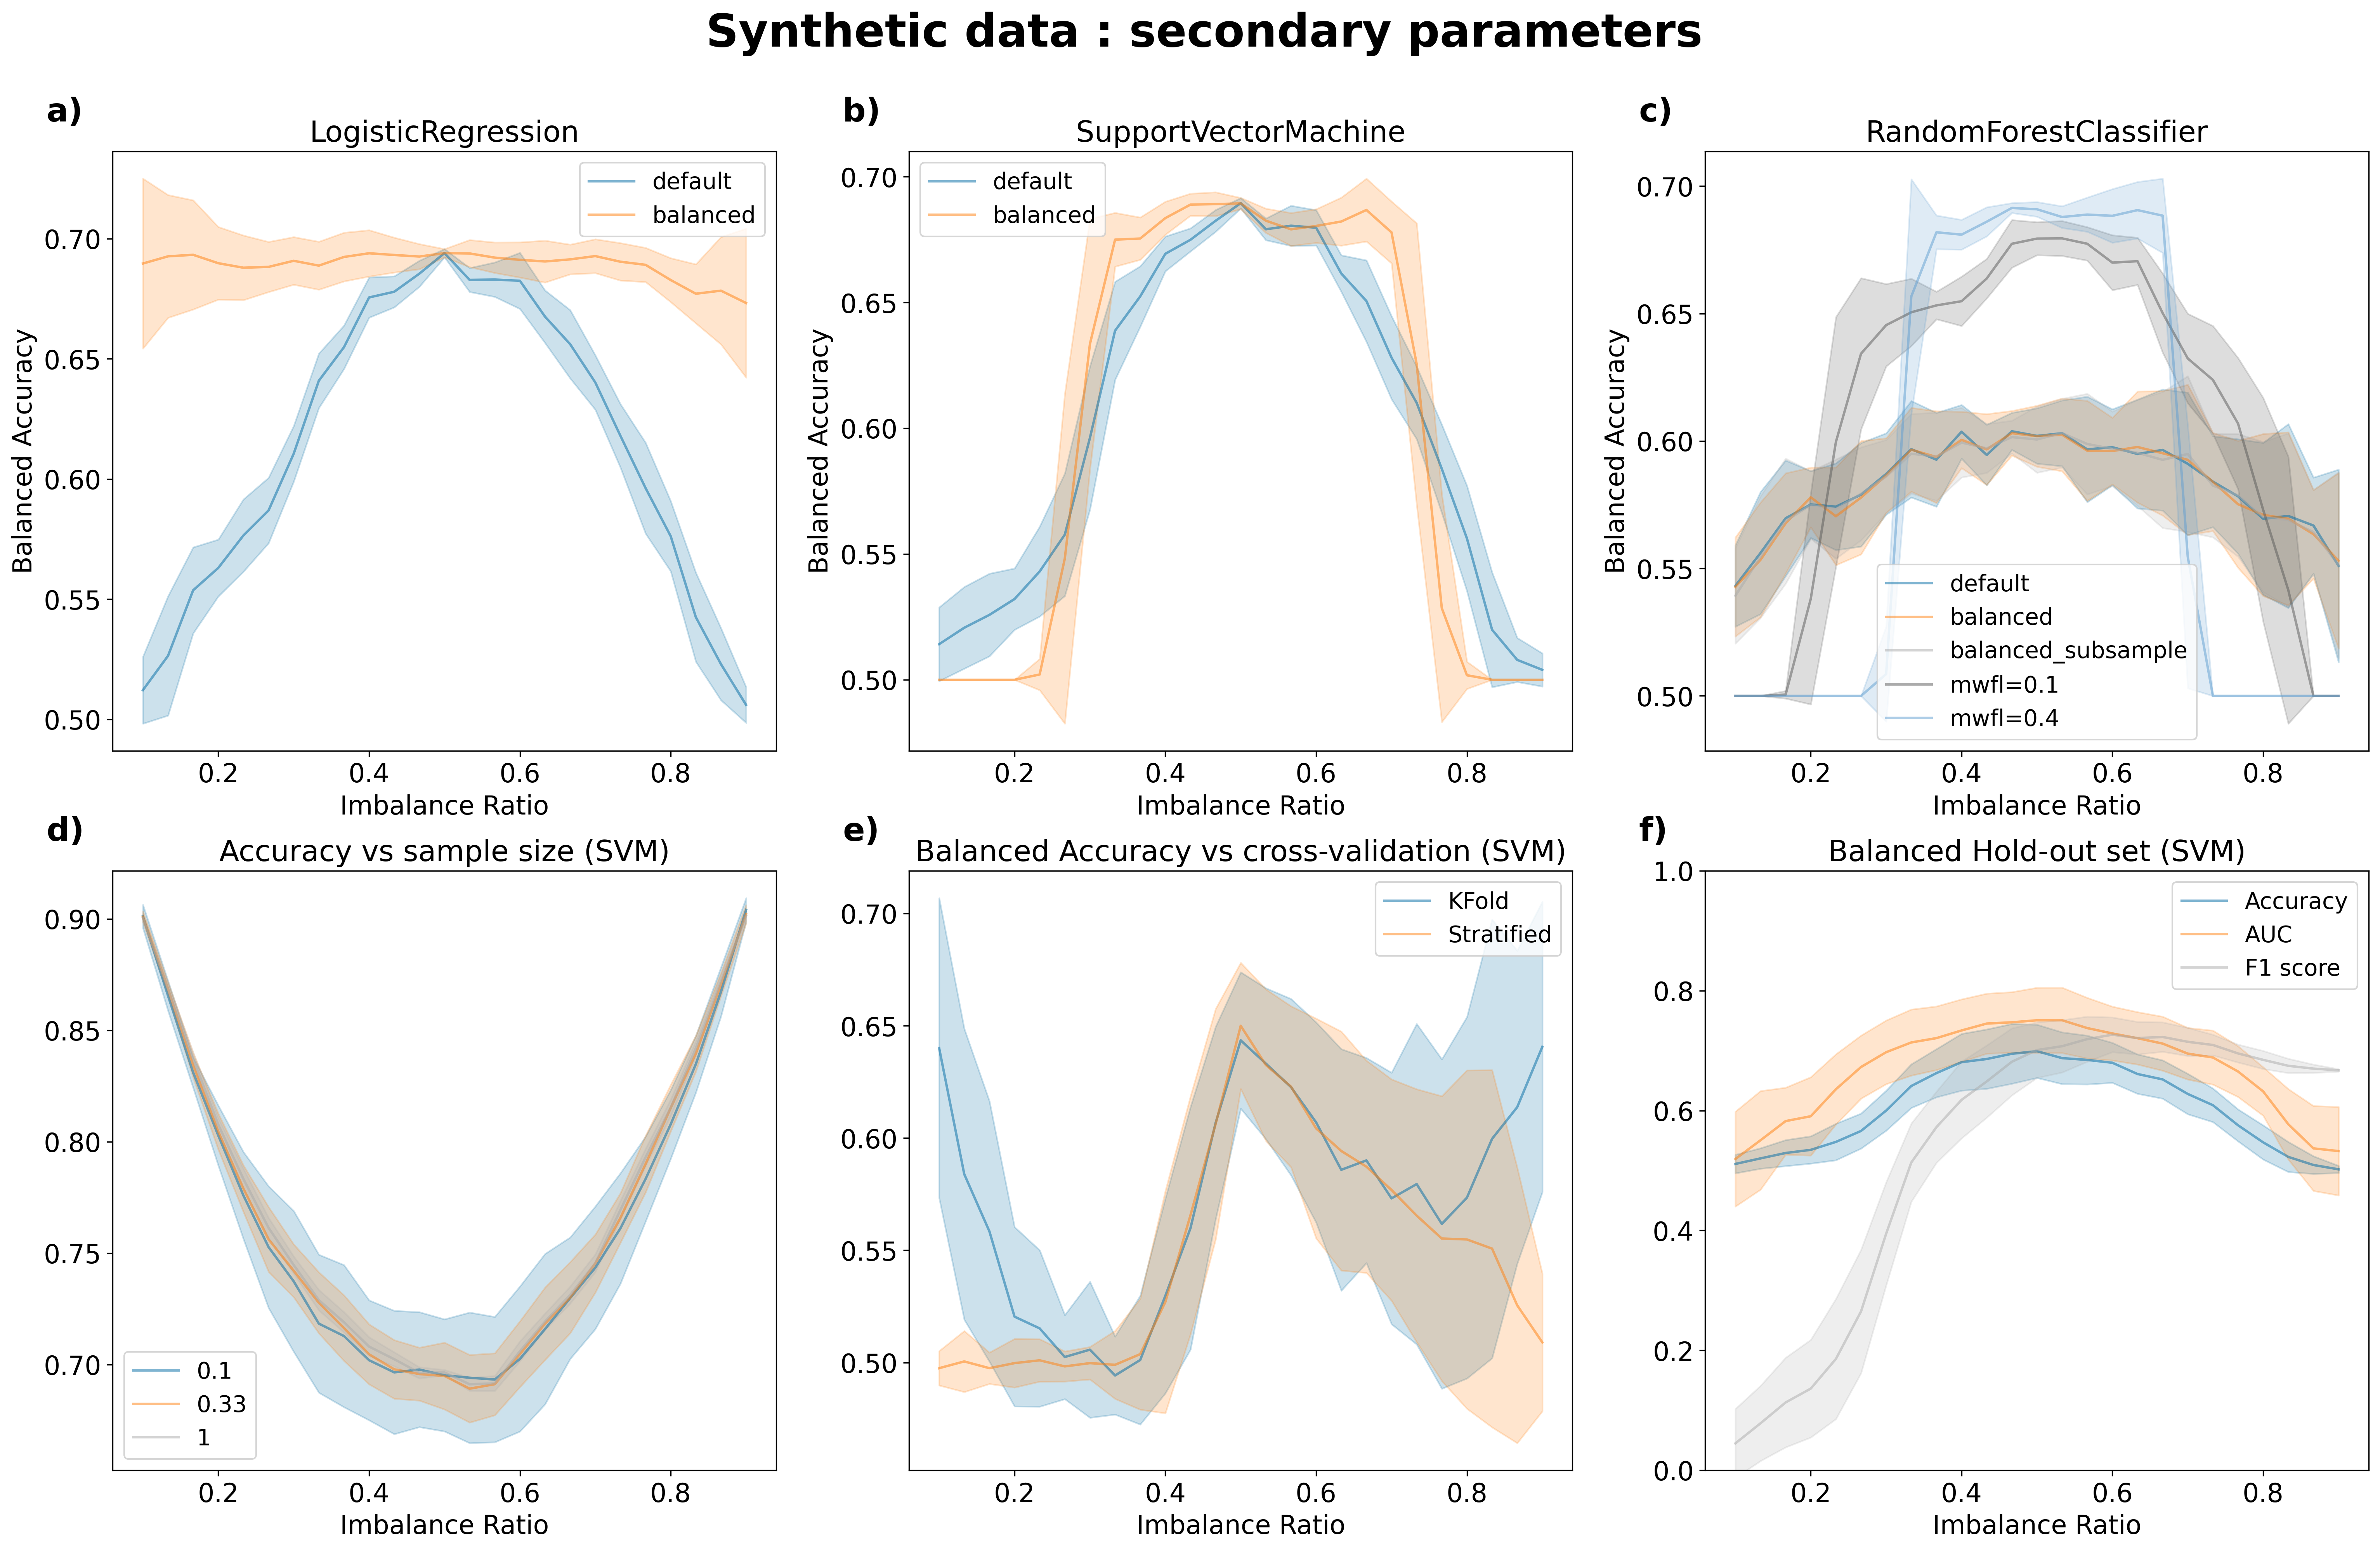

In [8]:
with open("../imbalance/data/synthetic_pipelines_nsamples.pickle", "rb") as f:
    pl_nsamples = pickle.load(f)
with open("../imbalance/data/synthetic_pipelines_crossvals.pickle", "rb") as f:
    pls_crossvals = pickle.load(f)
with open("../imbalance/data/synthetic_pipelines_balance.pickle", "rb") as f:
    pl_balance = pickle.load(f)
with open("../imbalance/data/hparams_pipelines.pickle", "rb") as f:
    pls_hparams = pickle.load(f)

fig, axes = plt.subplots(2, 3, figsize=(25, 15), dpi=300)
figtitle = "Synthetic data : secondary parameters"
fig.suptitle(figtitle, fontsize=28, y=0.96, fontweight="bold")


for clf_idx, clf_name in enumerate(pls_hparams.keys()):
    lines = []
    for i_pl, curr_pl in enumerate(pls_hparams[clf_name].values()):
        lines.extend(metric_balance(curr_pl, classifier=clf_name, color_offset=i_pl, ax=axes[0, clf_idx], 
                                    ignore_metrics=["roc_auc", "f1", "accuracy"],
                                    show=False, show_leg=True, enforce_ylim=False, reset_colors=True))
    axes[0, clf_idx].legend(lines, pls_hparams[clf_name].keys(), prop={'size': 14})
    axes[0, clf_idx].set_ylabel("Balanced Accuracy", size=16)


    
plot_different_n(pl_nsamples, ax=axes[1,0], show=False, classifier="svm", show_leg=True, metric="accuracy")
axes[1,0].set_title('Accuracy vs sample size (SVM)', size=18)

plot_different_cvs(pls_crossvals, ax=axes[1,1], show=False, classifier="svm", show_leg=True, metric="balanced_accuracy")
axes[1,1].set_title('Balanced Accuracy vs cross-validation (SVM)', size=18)

metric_balance(pl_balance, ax=axes[1,2], show=False, classifier="svm", show_leg=True, chance_leg=False, ignore_metrics=['balanced_accuracy'])
axes[1,2].set_title('Balanced Hold-out set (SVM)', size=18)

spot_names = string.ascii_lowercase[:5*4]
for ax_idx, ax in enumerate(axes.flat):
    ax.text(-0.1, 1.05, spot_names[ax_idx]+")", transform=ax.transAxes, 
    size=20, weight='bold')

In [ ]:
# Change the title of last Balance hold-out set

In [ ]:
plot_different_n(pl_nsamples, show=False, classifier="svm", show_leg=True, metric="accuracy")

## Task 2 : EEG analysis

In [ ]:
#pipeline_path="../imbalance/data/eeg.pickle"
features_path ="../imbalance/data/eeg_features.npy"

# load or generate dataset
if not os.path.isfile(features_path):
    x, y, groups = eegbci('../imbalance/data',roi=lambda x: x[0] in ['P','O'])
    np.save(features_path,dict(x=x, y=y, groups=groups))
else:
    features = np.load(features_path,allow_pickle=True).item()
    x, y, groups = features["x"] , features["y"] , features["groups"]

In [ ]:
pl = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["lda","svm","lr", "rf"]
)
# fit and evaluate classifiers on dataset configurations
pl.evaluate()

pl_nsamples = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],# "rf"]
    n_permutations=0,
    n_init=10,
    dataset_size=(0.1, 0.33, 1),
)
pl_nsamples.evaluate()

In [ ]:
fpath = "../imbalance/data/eeg_roi_multi_Stratified-Group.pickle"
with open(fpath, "rb") as f:
    pl = pickle.load(f)

def task_panel(pl: Pipeline, figtitle: str=[], class_names=[]):
    # visualize the result
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    #fig.suptitle(figtitle, fontsize=25)
    classifiers=["lr", "lda", "svm", "rf"]
    show_leg_metric=True
    for ax_idx,ax in enumerate(axes.flat):
        if ax_idx != 5:
            ax.text(-0.1, 1.05, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
                    size=20, weight='bold')
        if ax_idx == 0:
            data_distribution(pl, ax=ax, show=False, class_names=class_names)
        elif ax_idx < 5:
            metric_balance(pl, ax=ax, show=False, classifier=classifiers[ax_idx-1], p_threshold=0, show_leg=show_leg_metric)
            show_leg_metric=False
        elif ax_idx == 5:
            ax.axis('off')
            #plot_different_n(pl_nsamples, ax=ax, show=False, classifier="svm", show_leg=True, metric="accuracy")
    plt.show()

figtitle = "EEG data multi"
task_panel(pl, figtitle, ['Eyes closed', 'Eyes open'])

Extracting EDF parameters from /home/hyruuk/GitHub/CoCoLab/data-imbalance/notebooks/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


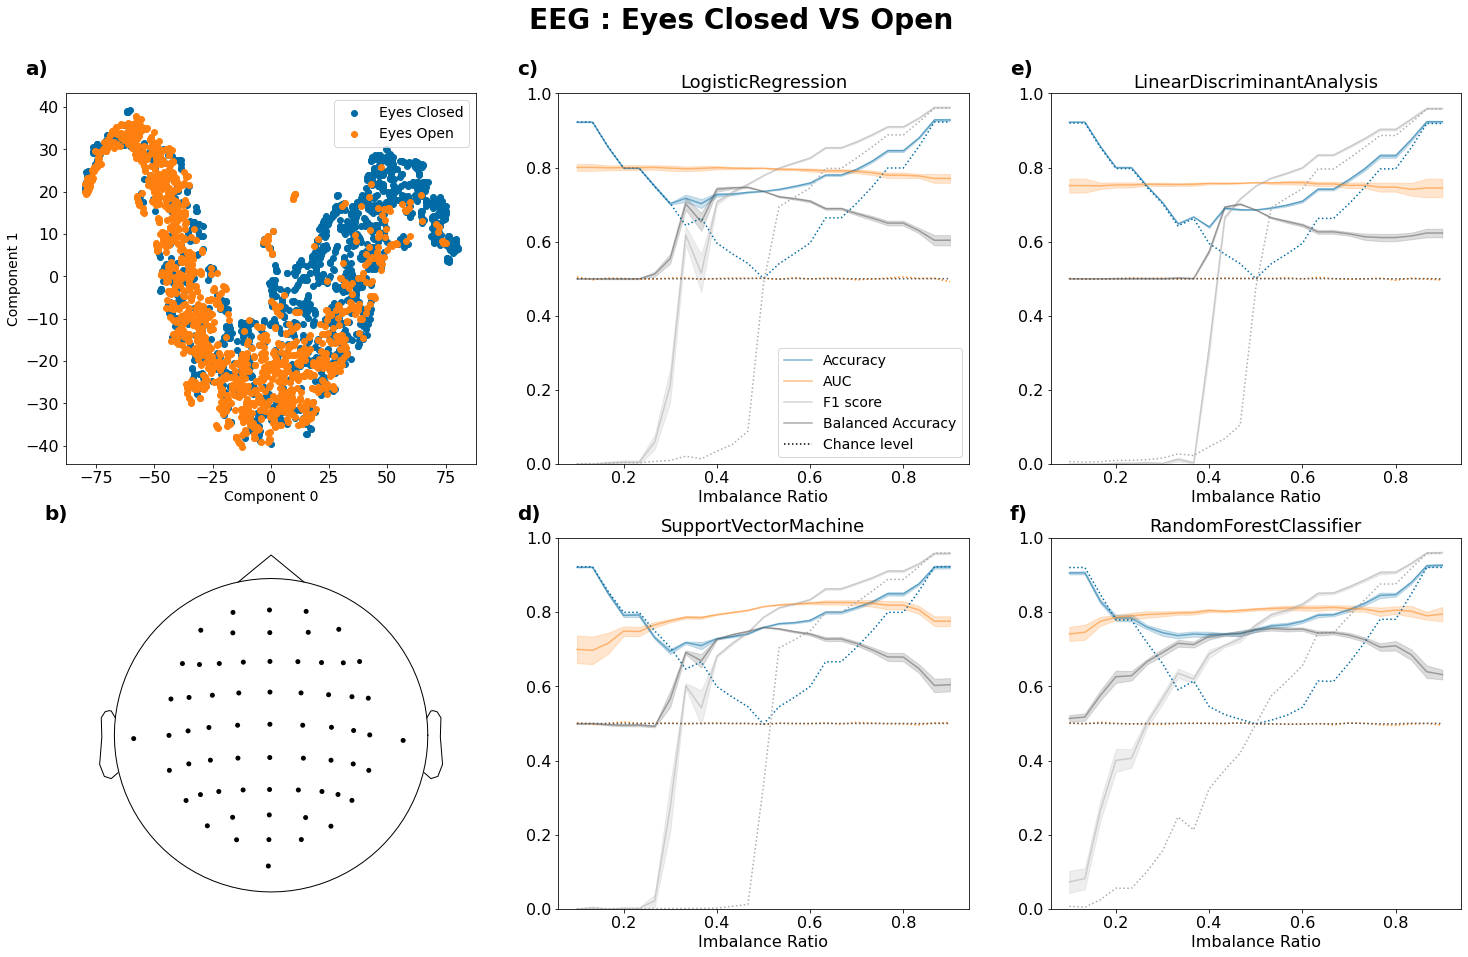

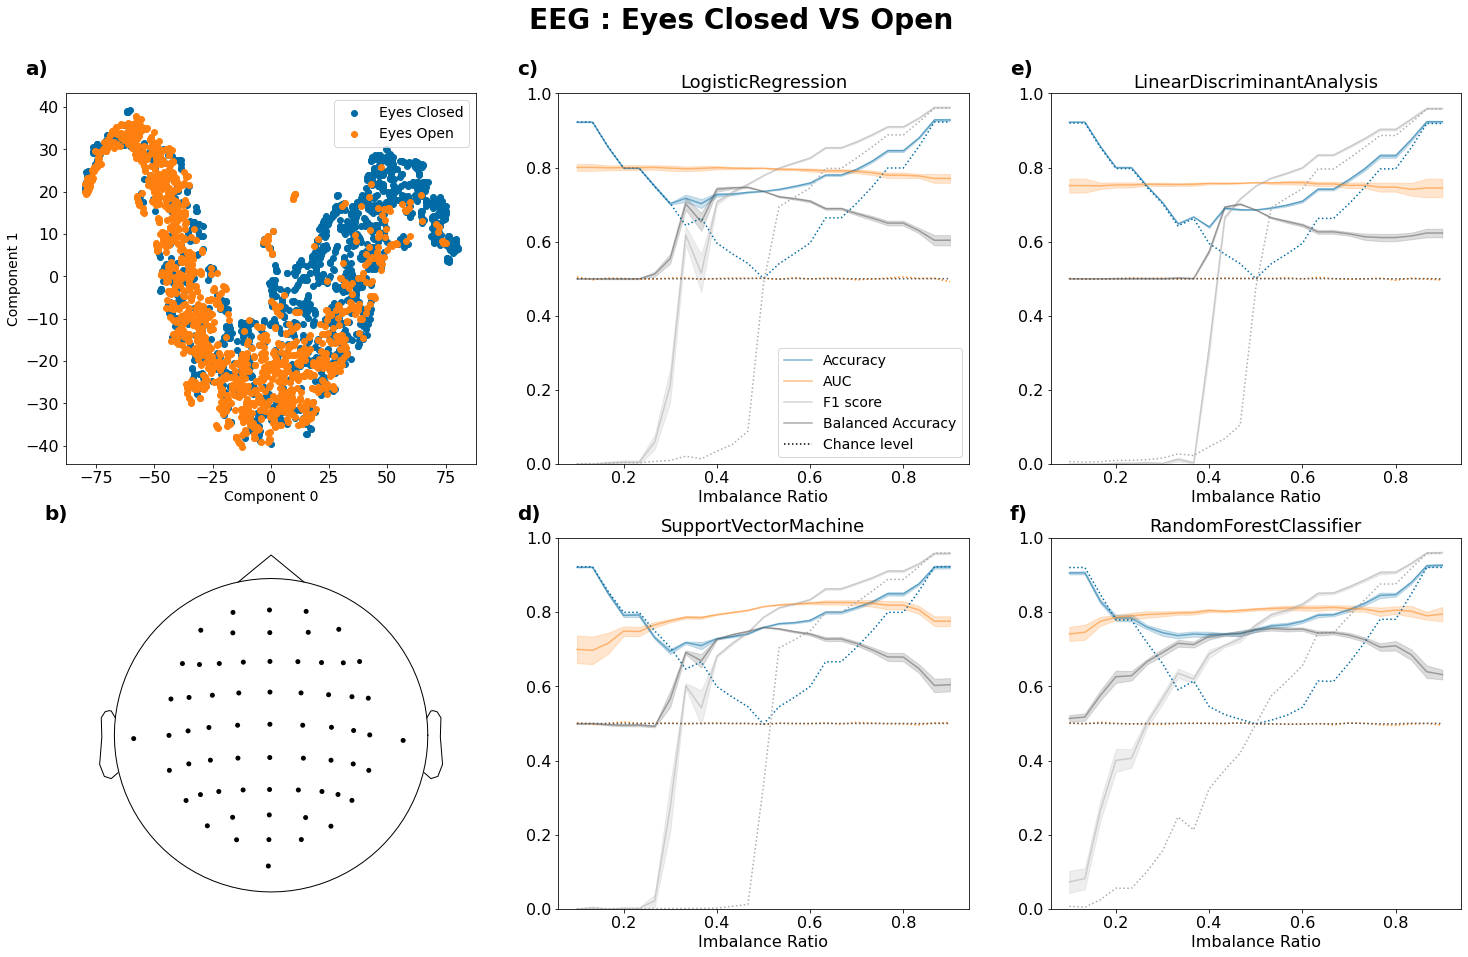

In [14]:
from imbalance.data.eeg import get_info
import mne

fpath = "../imbalance/data/eeg_roi_multi_Stratified-Group.pickle"
with open(fpath, "rb") as f:
    pl = pickle.load(f)
#tval = np.load("../imbalance/data/gamma1_tvalues.npy")    

figtitle = "EEG : Eyes Closed VS Open"
class_names = ['Eyes Closed', 'Eyes Open']
# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(25, 15))
fig.suptitle(figtitle, fontsize=28, y=0.96, fontweight="bold")
classifiers=["lr", "lda", "svm", "rf"]

data_distribution(pl, ax=axes[0,0], show=False, class_names=class_names)
#axes[0,0].set_xlim(-2.5,5)
axes[1,0].axis('off')

info = get_info()
roi = [x for x in info['ch_names'] if x[0] in ['P','O']]
sphere=(0, 0.015, 0.01, 0.115)


#generate_topomap(tval, ax=axes[1,0], elec=78)
#axes[1,0].set_xlabel('t-values', fontsize=16)

metric_balance(pl, ax=axes[0,1], show=False, classifier="lr", p_threshold=0, show_leg=True)
metric_balance(pl, ax=axes[0,2], show=False, classifier="lda", p_threshold=0, show_leg=False)
metric_balance(pl, ax=axes[1,1], show=False, classifier="svm", p_threshold=0, show_leg=False)
metric_balance(pl, ax=axes[1,2], show=False, classifier="rf", p_threshold=0, show_leg=False)

for ax_idx,ax in enumerate(axes.T.flat):
    ax.text(-0.1, 1.05, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
        size=20, weight='bold')
mne.viz.plot_sensors(info,axes=axes[1,0],sphere=sphere,pointsize=25,linewidth=0,block=True,show_names=False)
# TODO adjust letters

## Task 3 : MEG 1

In [12]:
from scipy.stats import ttest_ind
import string
from copy import deepcopy
import pickle
import numpy as np
import mne
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_info():
    data_path = mne.datasets.sample.data_path()
    raw = mne.io.read_raw_fif(
        f"{data_path}/MEG/sample/sample_audvis_raw.fif", preload=False
    )
    return raw.pick_types(meg="mag").info

# TODO move colorbar to the bottom
def generate_topomap(
    data,
    elec=None,
    ax= None,
    vmin=None,
    vmax=None,
    res=128,
    cmap="viridis",
    colorbar=True,
    tight_layout=True,
    mask=None,
    mask_params=None,
):    
    if elec is not None:
        mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=20)
        mask = np.zeros(102).astype(bool)
        mask[elec] = True
    
    if ax is None:
        fig, ax = plt.subplots()
    
    im, _ = plot_topomap(
        data,
        load_info(),
        axes=ax,
        res=128,
        cmap=cmap,
        vmax=data.max() if vmax is None else vmax,
        vmin=data.min() if vmin is None else vmin,
        show=False,
        show_names=False,
        contours=1,
        extrapolate="local",
        mask=mask,
        mask_params=mask_params,
    )
    
    divider = make_axes_locatable(ax)
    ax_colorbar = divider.append_axes('bottom', size='5%', pad=0.05)
    plt.colorbar(im, cax=ax_colorbar, orientation='horizontal')
    ax_colorbar.set_xlabel('t-values', fontsize=16)

Opening raw data file /home/hyruuk/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


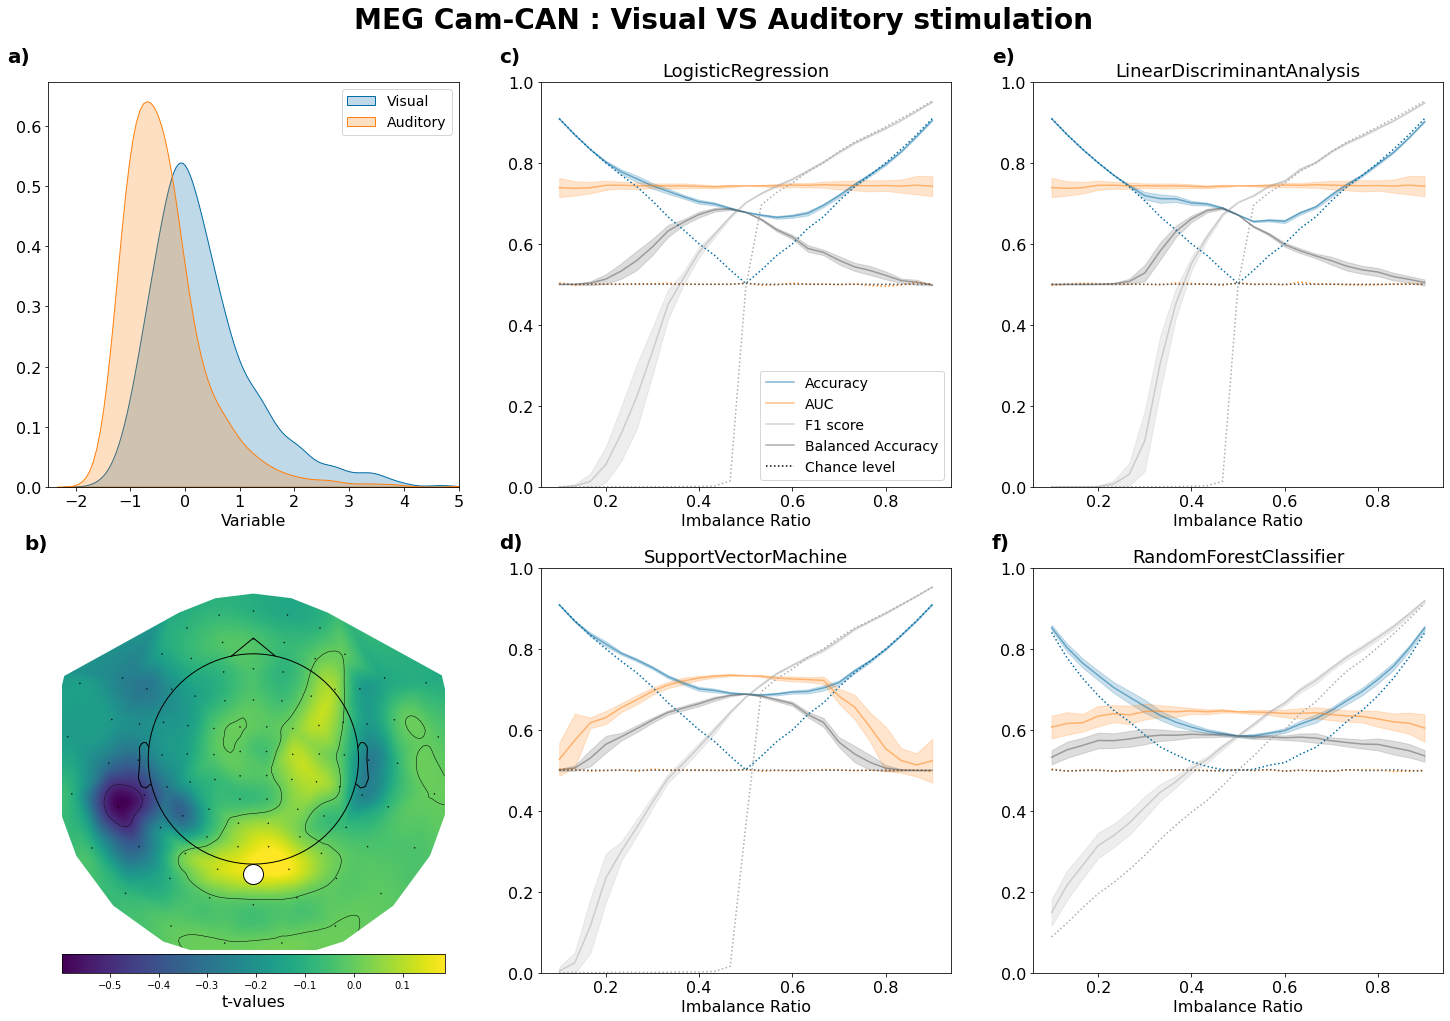

In [13]:

fpath = "../imbalance/data/MEG_gamma1_imbalance_78.pckl"
with open(fpath, "rb") as f:
    pl = pickle.load(f)
tval = np.load("../imbalance/data/gamma1_tvalues.npy")    

figtitle = "MEG Cam-CAN : Visual VS Auditory stimulation"
class_names = ['Visual', 'Auditory']
# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(25, 15))
fig.suptitle(figtitle, fontsize=28, y=1.02, fontweight="bold")
classifiers=["lr", "lda", "svm", "rf"]

data_distribution(pl, ax=axes[0,0], show=False, class_names=class_names)
axes[0,0].set_xlim(-2.5,5)

generate_topomap(tval, ax=axes[1,0], elec=78)
axes[1,0].set_xlabel('t-values', fontsize=16)

metric_balance(pl, ax=axes[0,1], show=False, classifier="lr", p_threshold=0, show_leg=True)
metric_balance(pl, ax=axes[0,2], show=False, classifier="lda", p_threshold=0, show_leg=False)
metric_balance(pl, ax=axes[1,1], show=False, classifier="svm", p_threshold=0, show_leg=False)
metric_balance(pl, ax=axes[1,2], show=False, classifier="rf", p_threshold=0, show_leg=False)

for ax_idx,ax in enumerate(axes.T.flat):
    ax.text(-0.1, 1.05, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
        size=20, weight='bold')

## Task 4 : MEG 2

In [ ]:

fpath = "../imbalance/data/MEG_gamma1_imbalance_78.pckl"
with open(fpath, "rb") as f:
    pl = pickle.load(f)
tval = np.load("../imbalance/data/gamma1_tvalues.npy")    

figtitle = "MEG Cam-CAN : Visual VS Auditory stimulation"
class_names = ['Visual', 'Auditory']
# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle(figtitle, fontsize=28, y=1.02, fontweight="bold")
classifiers=["lr", "lda", "svm", "rf"]

data_distribution(pl, ax=[0,0], show=False, class_names=class_names)
axes[0,0].set_xlim(-2.5,5)

generate_topomap(tval, ax=ax[1,0], elec=78)

metric_balance(pl, ax=ax[0,1], show=False, classifier="lr", p_threshold=0, show_leg=True)
metric_balance(pl, ax=ax[0,2], show=False, classifier="lda", p_threshold=0, show_leg=False)
metric_balance(pl, ax=ax[1,1], show=False, classifier="svm", p_threshold=0, show_leg=False)
metric_balance(pl, ax=ax[1,2], show=False, classifier="rf", p_threshold=0, show_leg=False)

show_leg_metric=True
for ax_idx,ax in enumerate(axes.flat):
    if ax_idx != 5:
        ax.text(-0.1, 1.05, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
                size=20, weight='bold')
    if ax_idx == 0:
        data_distribution(pl, ax=ax, show=False, class_names=class_names)
        ax.set_xlim(-2.5,5)
    elif ax_idx < 5:
        metric_balance(pl, ax=ax, show=False, classifier=classifiers[ax_idx-1], p_threshold=0, show_leg=show_leg_metric)
        show_leg_metric=False
    elif ax_idx == 5:
        generate_topomap(tval, ax=ax, elec=78)
        #ax.axis('off')
        #plot_different_n(pl_nsamples, ax=ax, show=False, classifier="svm", show_leg=True, metric="accuracy")
plt.show()

#task_panel(pl, figtitle, '])